### Preparing the env dependencies

In [1]:
import kagglehub
import spacy
import string
import re
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from kagglehub import KaggleDatasetAdapter
from wordcloud import WordCloud
from collections import Counter
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Dropout
from tensorflow.keras.layers import TextVectorization

/home/ja1/Faculdade/recpad/hybrid-classification-resumes/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-06-20 22:26:23.456819: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750469183.468042   16470 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750469183.471329   16470 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750469183.480809   16470 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linki

### Load the latest version of dataset

In [11]:
def getting_datasets(kaggle_paths, online=False):
  datasets = []
  for path, name, columns in kaggle_paths:
    save_path = f"data/{name}"
    try:
        if online:
            df = kagglehub.load_dataset(KaggleDatasetAdapter.PANDAS, path, name)
            df.to_csv(save_path, encoding='utf-8', index=False)
        else:
            df = pd.read_csv(save_path)
        df = df[columns]
        df = df.rename(columns={columns[0]: "resume", columns[1]: "category"})
        df.drop_duplicates()
        print(save_path, df)
        datasets.append(df)
    except:
      print("Error loading dataset", path, name)
      continue
  return datasets

In [12]:
kaggle_paths = [
    ("surendra365/recruitement-dataset", "job_applicant_dataset.csv", ["Resume", "Job Roles"]),
    ("jithinjagadeesh/resume-dataset", "gpt_dataset.csv", ["Resume", "Category"]),
    ("gauravduttakiit/resume-dataset", "UpdatedResumeDataSet.csv", ["Resume", "Category"]),
    ("snehaanbhawal/resume-dataset", "Resume/Resume.csv", ["Resume_str", "Category"]),
    ("noorsaeed/resume-datasets", "clean_resume_data.csv", ["Feature", "Category"]),
]
datasets = getting_datasets(kaggle_paths)

data/job_applicant_dataset.csv                                                  resume              category
0     Proficient in Injury Prevention, Motivation, N...         Fitness Coach
1     Proficient in Healthcare, Pharmacology, Medica...             Physician
2     Proficient in Forecasting, Financial Modelling...     Financial Analyst
3     Proficient in Budgeting, Supply Chain Optimiza...  Supply Chain Manager
4     Proficient in Logistics, Negotiation, Procurem...  Supply Chain Manager
...                                                 ...                   ...
9995  Proficient in Biology, Regulatory Compliance, ...   Biomedical Engineer
9996  Proficient in Communication, Teamwork, Lesson ...               Teacher
9997  Proficient in Medical Terminology, Critical Th...             Physician
9998  Proficient in Exercise Programming, Motivation...         Fitness Coach
9999  Proficient in Content Strategy, Copywriting, C...        Content Writer

[10000 rows x 2 columns]
data/gp

### Preprocessing dataset

In [14]:
def clean_text(text):
  text = str(text).lower()  # Convert to lowercase
  text = re.sub(r'\n', ' ', text)  # Remove newlines
  text = re.sub(r'\[.*?\]', '', text)  # Remove text in brackets
  text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)  # Remove punctuation
  text = re.sub(r'\w*\d\w*', '', text)  # Remove words with numbers
  text = re.sub(r'https?://\S+|www\.\S+|ftp\.\S+', '', text) # remove ulrs
  text = re.sub(r'\S+@\S+', '', text) # remove emails
  text = re.sub('[^A-Za-z0-9 ]+', '', text) # no special character but space
  text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
  return text.strip()

nlp = spacy.load('en_core_web_sm')
def remove_stopwords(text):
  doc = nlp(text)
  tokens = [token.text for token in doc if not token.is_stop]
  return ' '.join(tokens)

def lemmatizing(text):
  doc = nlp(text)
  lemmatized_tokens = [token.lemma_ for token in doc]
  return ' '.join(lemmatized_tokens)

def cleaning_datasets(datasets, columns):
  for i, df in enumerate(datasets):
    for col in columns:
      df[col] = df[col].apply(clean_text)
      df[col] = df[col].apply(remove_stopwords)
      df[col] = df[col].apply(lemmatizing)
    df = df.drop_duplicates()
    df.to_csv(f"data/filtered/df_{i}.csv", encoding='utf-8', index=False)
  return datasets

In [15]:
text_columns = ['resume', 'category']
clean_df = cleaning_datasets(datasets, text_columns)

all_data = pd.concat(clean_df, ignore_index=True)
all_data = all_data.drop_duplicates()
all_data.to_csv('data/filtered/data_clean.csv', encoding='utf-8', index=False)
all_data.shape

(15308, 2)

Catching off-line data

In [16]:
all_data = pd.read_csv("data/filtered/data_clean.csv")
all_data = all_data.dropna()
all_data = all_data.drop_duplicates()
all_data.shape

(15306, 2)

### Data Mining

Word of clouds

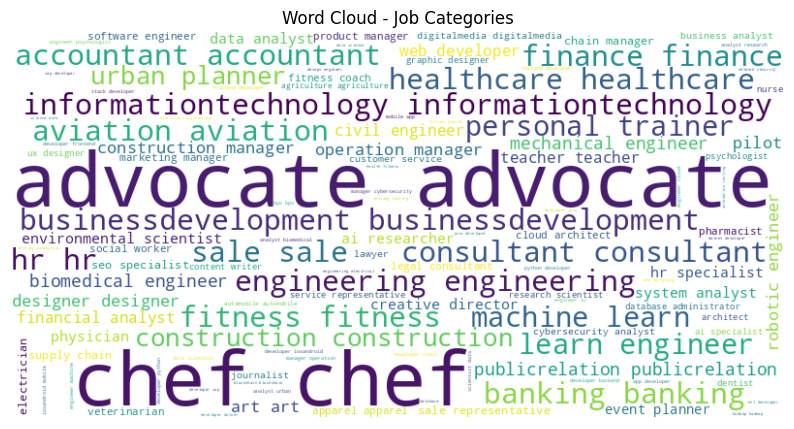

In [17]:
categories = " ".join(all_data['category'])
wordcloud_categories = WordCloud(width=800, height=400, background_color='white').generate(categories)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_categories, interpolation='bilinear')
plt.title("Word Cloud - Job Categories")
plt.axis('off')
plt.show()

Resume instances for each job category

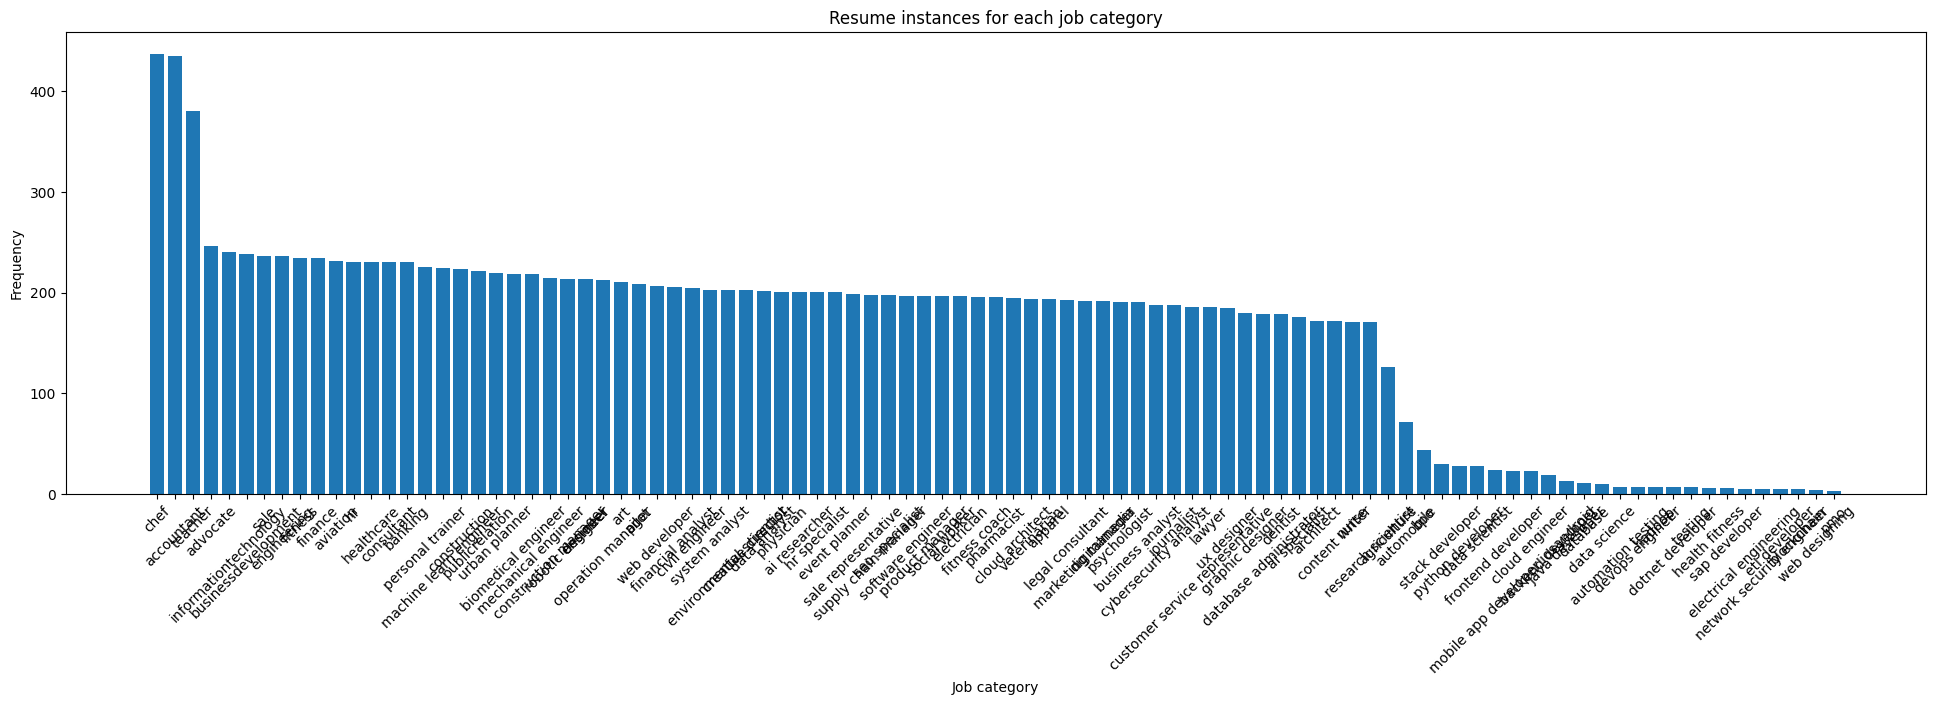

In [19]:
category_counts = Counter(all_data['category'])
common_words = category_counts.most_common(len(category_counts))
words, counts = zip(*common_words)

plt.figure(figsize=(24, 6))
plt.bar(words, counts)
plt.title("Resume instances for each job category")
plt.xlabel("Job category")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()

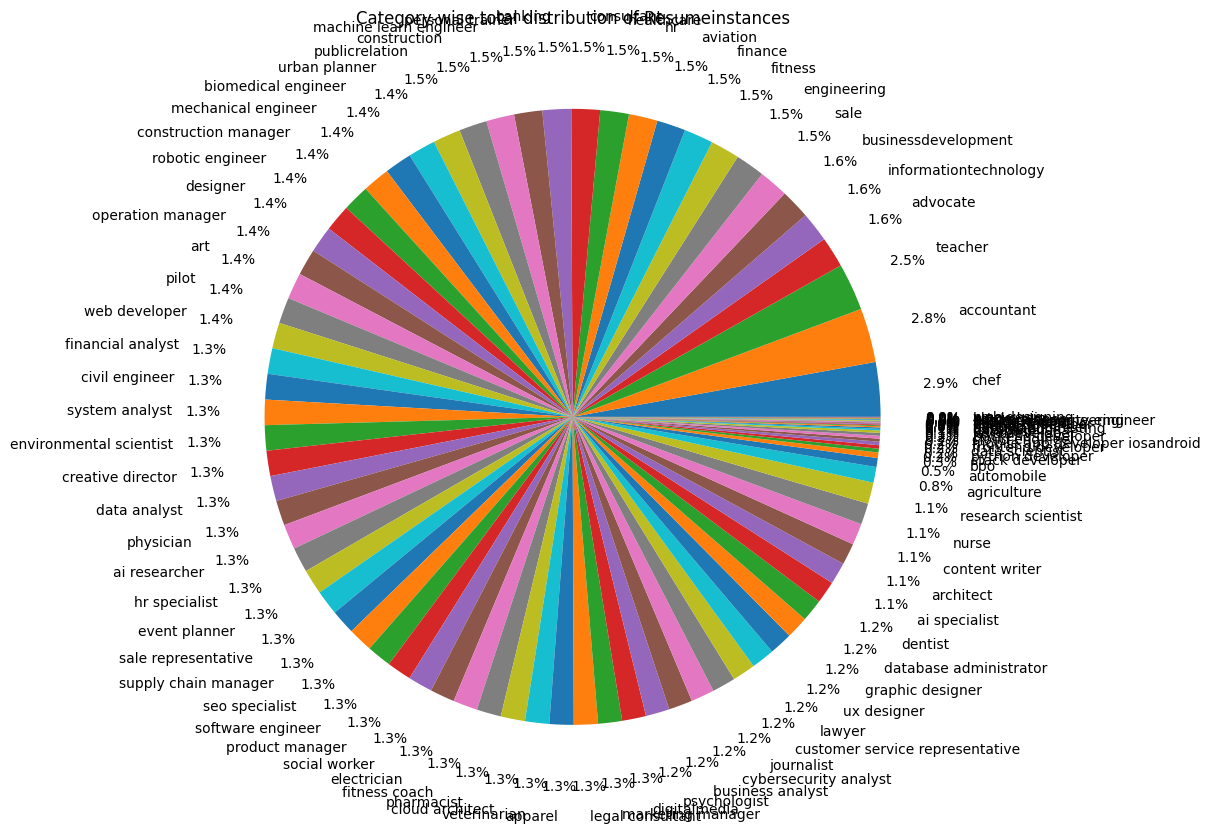

In [20]:
sizes = [c/len(category_counts) for c in counts]

plt.figure(figsize=(20, 10))
plt.pie(sizes, labels=words, autopct='%1.1f%%', pctdistance=1.2, labeldistance=1.3)
plt.title("Category-wise total distribution of Resumeinstances")
plt.show()

In [21]:
category_tb = pd.DataFrame({'job category': words, 'count': counts, 'sizes (%)': sizes})
category_tb

,job category,count,sizes (%)
0,chef,437,4.600000
1,accountant,435,4.578947
2,teacher,380,4.000000
3,advocate,246,2.589474
4,informationtechnology,240,2.526316
...,...,...,...
90,network security engineer,5,0.052632
91,etl developer,5,0.052632
92,blockchain,5,0.052632
93,web designing,4,0.042105


### Vectorizer

Label Encoder

In [9]:
categories = all_data['category']
labelencoder = LabelEncoder()
category_encoded = labelencoder.fit_transform(categories)
print(category_encoded)
num_categories = len(list(set(category_encoded)))

[48 70 46 ... 10 10 10]


In [10]:
y = to_categorical(category_encoded)
print(num_categories, y)

95 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


TF-IDF

In [11]:
tfidf_vec = TfidfVectorizer()
resumes_vec = tfidf_vec.fit_transform(all_data['resume'])
inputs = len(tfidf_vec.get_feature_names_out())
print("Tamanho:", len(tfidf_vec.get_feature_names_out()), "Vocabulário:", tfidf_vec.get_feature_names_out(), )
resumes_vec

Tamanho: 46095 Vocabulário: ['aa' 'aaa' 'aaacom' ... 'zyvox' 'zz' 'zzxzx']


<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 989655 stored elements and shape (12830, 46095)>

Tokens

In [26]:
token = Tokenizer(num_words=10000)
token.fit_on_texts(all_data['resume'].values)
inputs = len(token.word_index)
resumes_token = token.texts_to_sequences(all_data['resume'].values)
resumes_token = pad_sequences(resumes_token, padding="post", maxlen=1000)
inputs, resumes_token

(46119,
 array([[  12,  888,  743, ...,    0,    0,    0],
        [  12,  286, 1224, ...,    0,    0,    0],
        [  12,  644,   47, ...,    0,    0,    0],
        ...,
        [ 450,  116,   54, ...,    0,    0,    0],
        [8373, 4106,  696, ...,    0,    0,    0],
        [  45,  169,   55, ...,    0,    0,    0]], dtype=int32))

Word embeddings

In [12]:
!pip install -q gensim

In [15]:
!pip install -q --upgrade numpy gensim --no-cache-dir

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 143.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [16]:
import nltk
nltk.download('punkt_tab')
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [75]:
modelW2V = Word2Vec(sentences=all_data['resume'], vector_size=16, window=20, sg=0, min_count=1, workers=4)
modelW2V.train(all_data['resume'], total_examples=len(all_data['resume']), epochs=20)

In [ ]:
filename = 'word2vec_model.pkl'
with open(filename, 'wb') as file:
    pickle.dump(modelW2V, file)

In [ ]:
with open(filename, 'rb') as file:
    modelW2V = pickle.load(file)

In [ ]:
def document_vector(doc, model):
#  Remove out-of-vocabulary words
  doc = [word for word in doc if word in model.wv.index_to_key]
  return np.mean(model.wv[doc], axis=0) if doc else np.zeros(model.vector_size)

In [ ]:
resumes_w2v = np.array([document_vector(doc, modelW2V) for doc in all_data['resume']])

## Training models

In [41]:
x = resumes_vec # could be resumes_vec, resumes_token and vectorize_layer
X_train, X_temp, y_train, y_temp = train_test_split(x, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
X_train.shape, X_temp.shape, X_val.shape, X_test.shape

((10264, 46095), (2566, 46095), (1283, 46095), (1283, 46095))

### Random Forests

In [42]:
model_RF = None;
better_score = 0;
for n in [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]:
  forest = RandomForestClassifier(n_estimators=n, criterion='entropy', bootstrap=False)
  forest.fit(X_val, y_val)
  prediction = forest.predict(X_test)
  score = metrics.accuracy_score(y_test, prediction)
  print(n, score)
  if score > better_score:
    model_RF = forest
    better_score = score

print("Better accuracy:", better_score)

100 0.5572876071706937
200 0.5837879968823071
300 0.5876851130163678
400 0.5814497272018706
500 0.5705378020265004
600 0.578332034294622
700 0.5767731878409976
800 0.5869056897895557
900 0.5814497272018706
1000 0.5892439594699922
Better accuracy: 0.5892439594699922


In [ ]:
model_RF.fit(X_train, y_train)
prediction = model_RF.predict(X_test)
print(accuracy_score(y_test, prediction))
print(metrics.classification_report(y_test, prediction))

In [ ]:
filename = '/content/drive/My Drive/POLI/msc/recpad/models/RFC_model.pkl'
with open(filename, 'wb') as file:
    pickle.dump(model_RF, file)

### MLP

In [30]:
forestMLP = MLPClassifier(hidden_layer_sizes=500)
forestMLP.fit(X_val, y_val)

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=500)

In [31]:
predictionMLP = forestMLP.predict(X_test)
# print(confusion_matrix(y_test, predictionMLP))
print(accuracy_score(y_test, predictionMLP))
print(metrics.classification_report(y_test, predictionMLP))

0.0264797507788162
              precision    recall  f1-score   support

           0       0.11      0.10      0.10        20
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00         3
           3       0.12      0.15      0.14        13
           4       0.08      0.08      0.08        13
           5       0.00      0.00      0.00         6
           6       0.00      0.00      0.00        13
           7       0.00      0.00      0.00         4
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         6
          11       0.00      0.00      0.00         0
          12       0.00      0.00      0.00        11
          13       0.00      0.00      0.00        14
          14       0.00      0.00      0.00         0
          15       0.00      0.00      0.00         0
          16       0.00      0.00      0.00         4
        

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/me

### BERT Classification